# Predicting Oil Production from Exclusively Public Records

Without access to proprietary geological data, this project predicts the quantity of oil produced from wells in an area of northern Colorado using data that is exclusively public and sourced from [Colorado's official ECMC website](https://ecmc.state.co.us/). The ECMC makes some of the data clean and easy for bulk download, and other data was scraped from their website. All wells in the dataset were drilled horizontally in the "Niobrara" geological formation (or similar).

The model built in this project is in two parts:
 * a series of exponential regression models fit to each well's production data; and
 * a variation of KNN to create a composite exponential model.

Specifically, it finds the *k*-nearest wells, pulls the coefficients for their exponential regression models, and averages those coefficients into a composite exponential curve -- weighting the averages by distance to the target with inverse-distance weighting (IDW).

### Report Sections

* Dataset
  * Well Location Data
  * Monthly Production Data
* Model
  * Part 1 - Exponential Regression
  * Part 2 - KNN
* Hyperparameter Tuning
* Evaluation
* Future Improvements


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
from sklearn.model_selection import train_test_split

from model.exp_regress import ExpRegressionModel, train_all_exp_regress
from model.nearest_wells import get_distance_calculator
from model import CompositeModelBuilder
from preprocess.prod_records import ProductionLoader
import evaluate
import graph_results
import utils
# Some functions only used in this notebook.
import demo_utils

In [2]:
# Configure paths/filenames of trained models / parameter tuning.
TRAINED_EXP_REGRESS_MODELS_DIR = Path(r"trained_expregress_models")
TRAINED_EXP_REGRESS_FN_TEMPLATE = "exp_regress_models_{weight}.csv"
TUNING_RESULTS_FP = Path("tuning_results.csv")

# The Dataset

## Well Location Data

The data collection, combining, and preprocessing have mostly been completed and saved to `selected_wells_working_data.csv` prior to this demo.

Here's a quick explanation of the important data:
  * __API Number__ -- a unique identifier for each well, in the format `05-123-XXXXX`
  * __Surface hole location__ (SHL) -- the lat/long coord where the well is drilled at the surface
  * __Bottom hole location__ (BHL) -- the lat/long of the underground termination point of the lateral \*
  * __Midpoint__ between the SHL and BHL (itself a lat/long coord)
  * __Length__ of the underground lateral \*

  \* *The __lateral__ is the part of the well that is drilled horizontally, roughly parallel to the surface of the earth. More on that later.*

In [3]:
# Previously processed to add midpoints, lateral lengths, and other data.
well_data_fp = Path(r"../data/selected_wells_working_data.csv")
wells = pd.read_csv(well_data_fp)

In [4]:
important_fields = ['API_Label', 'lat_shl', 'long_shl', 'lat_bhl', 'long_bhl', 'lat_midpoint', 'long_midpoint', 'lateral_length_ft']
wells[important_fields].head()

,API_Label,lat_shl,long_shl,lat_bhl,long_bhl,lat_midpoint,long_midpoint,lateral_length_ft
0,05-123-31642,40.755031,-104.104749,40.74465,-104.09018,40.749841,-104.097465,5531.698517
1,05-123-32812,40.667909,-104.093667,40.65689,-104.09359,40.662399,-104.093628,4014.594797
2,05-123-33023,40.759280,-103.877940,40.75685,-103.86228,40.758065,-103.870110,4427.873055
3,05-123-33065,40.771792,-103.858169,40.77184,-103.85792,40.771816,-103.858045,71.151625
4,05-123-33067,40.759950,-103.880660,40.76011,-103.89240,40.760030,-103.886530,3252.887196


## Monthly Production Data

Each well's production records were downloaded separately. The only important data here for our purposes is the quantity of oil production (measured in barrels, or BBLs) each month.

In [5]:
# Utility to load monthly production records for a given well (by its API number).
PRODUCTION_RECORDS_DIR = Path(r"../data/production_records")
PRODUCTION_CSV_FN_TEMPLATE = "{api_num}_production_data.csv"
production_loader = ProductionLoader(
    prod_records_dir=PRODUCTION_RECORDS_DIR,
    prod_csv_template=PRODUCTION_CSV_FN_TEMPLATE,
    use_cache=True,  # Save some load time
    apply_get_prod_window=True,
    # kwargs for get_production_window(), to get consistent timeframe
    # for all wells in the train/test data.
    min_months=36,
    max_months=48,
    discard_gaps=True,
)

In [6]:
# Create a separate sample loader to pull the full production history for this demo.
example_loader = ProductionLoader(
    prod_records_dir=PRODUCTION_RECORDS_DIR,
    prod_csv_template=PRODUCTION_CSV_FN_TEMPLATE)
example_api_num = '05-123-31642'
example_prod = example_loader.load(example_api_num)
# We only care about which month and the quantity of monthly production.
relevant_fields = ['First of Month', 'Oil Produced']
example_prod[relevant_fields].head()

,First of Month,Oil Produced
3,2011-01-01,4957.0
4,2011-02-01,3579.0
5,2011-03-01,3766.0
6,2011-04-01,3185.0
7,2011-05-01,3032.0


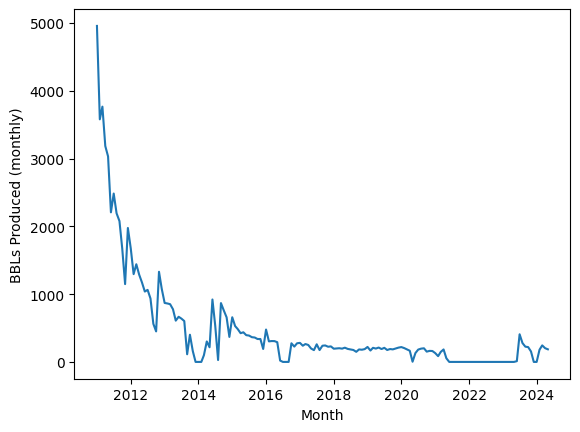

In [7]:
ax = plt.subplot()
ax.plot(example_prod['First of Month'], example_prod['Oil Produced'])
ax.set_xlabel('Month')
ax.set_ylabel('BBLs Produced (monthly)')
plt.show()

The actual quantity of oil or gas produced from a well is quite noisy, but overall it exhibits a ["decline curve"](https://www.investopedia.com/terms/d/decline-curve.asp). The vast majority of production from a well will be obtained shortly after its completion, then it tapers off significantly (unless the operator reworks the well later on). That means that investors will obtain nearly all of the income from a well early on, so we'll focus on the first four years for each well.

# The Model

## Part 1 - Exponential Regression

We model the decline curve by fitting an exponential curve to the actual production (reported monthly but predicted daily). We can use different weightings to skew the prediction more or less in favor of higher-producing months, which is one area for tuning later.

Specifically, weights for each data point are calculated as `(bbls_per_day / lateral_length_ft) ** exp_reg_power`, where `bbls_per_day / lateral_length_ft` is the target variable (which later gets converted to `bbls_per_day` when making predictions). The higher the power, the more strongly the curve is weighted toward large data points.

In [8]:
example_well = wells.iloc[0, :]
api_num = example_well['API_Label']
lat_len = example_well['lateral_length_ft']
monthly_prod_records_all = production_loader.load(api_num)
# Clean up the records so that we are looking only at the first 48 months of actual production.
monthly_prod_records = utils.get_prod_window(monthly_prod_records_all, min_months=36, max_months=48, discard_gaps=True)

# Different weightings we'll try.
exp_weight_pows = [2.0, 1.5, 1.0, 0.75, 0.5, 0.375, 0.25, 0.125]
# Store predictions for each model.
weights_predictions = {}

for wp in exp_weight_pows:
    exp_reg = ExpRegressionModel()
    exp_reg.fit(monthly_prod_records, lateral_length_ft=lat_len, weight_power=wp)
    cumulative_days = utils.get_cumulative_days(monthly_prod_records)
    predicted = exp_reg.predict_bbls_per_calendar_day(cumulative_days)
    weights_predictions[wp] = predicted

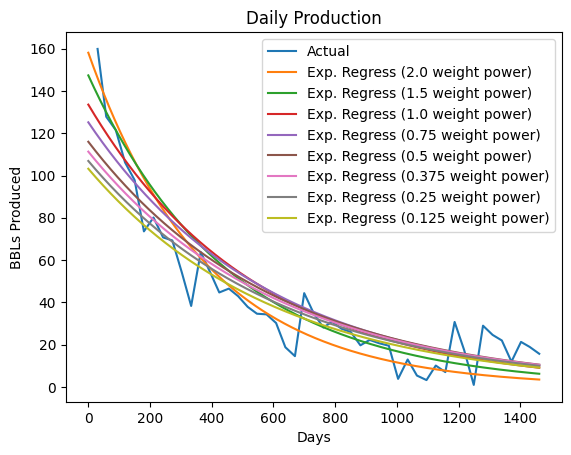

In [9]:
labels = [f"Exp. Regress ({wp} weight power)" for wp in weights_predictions.keys()]
all_predictions = list(weights_predictions.values())
graph_results.graph_results_multiple(monthly_prod_records, all_predictions, labels)

This is a two-part model that combines multiple exponential regression with KNN, so I'll hold off on assessing the different weightings.

For now, we can train exponential regression models for all wells in the dataset, using a weighting value of `0.5`. (We will later try different weightings during tuning.)

In [10]:
wp = 0.5
fp = TRAINED_EXP_REGRESS_MODELS_DIR / TRAINED_EXP_REGRESS_FN_TEMPLATE.format(weight=wp)
if fp.exists():
    print(f"Loading models with weight power {wp}... ", end='')
    expreg_models = pd.read_csv(fp)
else:
    print(f"Training all with weight power {wp}... ", end='')
    expreg_models = train_all_exp_regress(
        wells,
        prod_records_dir=PRODUCTION_RECORDS_DIR,
        prod_csv_template=PRODUCTION_CSV_FN_TEMPLATE,
        weight_power=wp,
    )
print("Done")

Loading models with weight power 0.5... Done


Some wells do not have the minimum number of months that saw any production (36 months in this demo), so we discard those wells before performing KNN.

In [11]:
# Whether there was enough data for a given well will not change based on
# the weighting used, so just grab the models for the first parameter set.
usable_api_nums = expreg_models[expreg_models['sufficient_data'] == True]['API_Label']
usable_wells = wells[wells['API_Label'].isin(usable_api_nums)]
print(f"{len(wells)} total wells")
print(f"{len(usable_wells)} wells with at least 36 months of production")

831 total wells
816 wells with at least 36 months of production


### Normalizing by length of lateral

One important note is that modern oil wells are drilled down to the target geological formation, and then across or "laterally" (roughly parallel to the surface of the earth). That part of the well is called the *__"lateral"__* (or sometimes the "horizontal leg"), and it can vary from a few hundred feet to several miles long. The longer the lateral, the more area the well is producing from. To account for this, we normalize the quantity of production (BBLs) to __BBLs *per foot*__ before training, and then convert back to (total) BBLs when making predictions. This is handled internally by the ``ExpRegressionModel`` class, and that's why `lateral_length_ft` is a parameter.

## Part 2 - KNN with Inverse-Distance Weighting (IDW)

Next, we find the k-nearest wells to our target, and then build an exponential regression model that is a *composite* of the models for those k-nearest wells. Specifically, we use IDW to determine the weighting of each component well (i.e., the closer the well to our target, the higher its weighting) and take the weighted average of each model's `a` and `b` coefficients.

For each well, we'll use the midpoint between the SHL and BHL as a proxy for its location, in order to simplify finding distances for KNN. Neither the SHL (location above ground) or BHL (termination point below ground) are suitable on their own for calculating distance, because two wells can be drilled right next to one another but then horizontally in opposite directions. In fact, this is extremely common, because it allows an operator to reduce the area they need to drill on, and it reduces the number of collection points for trucks and pipelines.

In [12]:
# Creating a calculator with all available wells allows for caching distance calculations.
dist_calculator = get_distance_calculator(wells=usable_wells)

k = 7
example_well = usable_wells.iloc[0, :]
target_api_num = example_well['API_Label']  # '05-123-31642'
lat_len = example_well['lateral_length_ft']
# For this demo, consider every well except the target well itself.
training_wells = usable_wells.drop(usable_wells[usable_wells['API_Label'] == target_api_num].index)
coefs = CompositeModelBuilder.extract_coefs_from_df(expreg_models)
builder = CompositeModelBuilder(training_wells, k, coefs, dist_calculator)
composite_model = builder.knn_well(target_api_num, idw_power=2)

In [13]:
monthly_prod_records_all = production_loader.load(api_num)
# Clean up the records so that we are looking only at the first 48 months of actual production.
monthly_prod_records = utils.get_prod_window(monthly_prod_records_all, min_months=36, max_months=48, discard_gaps=True)
cumulative_days = utils.get_cumulative_days(monthly_prod_records)
predicted = composite_model.predict_bbls_per_calendar_day(cumulative_days, lateral_length_ft=lat_len)

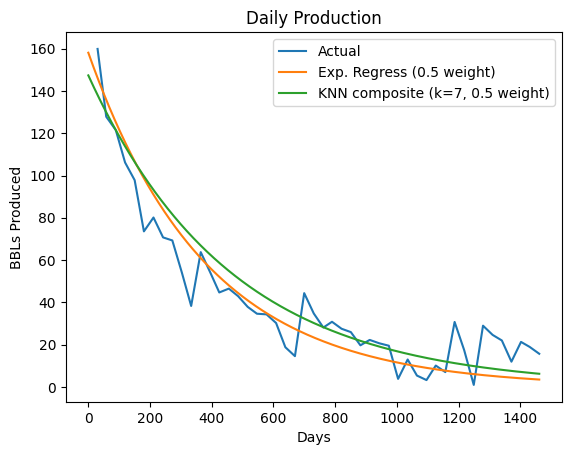

In [14]:
all_predictions.append(predicted)
selected_predictions = [all_predictions[4], predicted]
graph_results.graph_results_multiple(monthly_prod_records, all_predictions, prediction_labels=['Exp. Regress (0.5 weight)', 'KNN composite (k=7, 0.5 weight)'])

The graph above shows the actual production for this well, and two curves showing the predictions. One prediction curve is the exponential regression that was fitted to this well's actual production (using 0.5 weighting); and the other is the composite model, drawing instead from the 7 nearest wells (excluding this well itself).

# Hyperparameter Tuning

We'll do a 75/25 train/test split, then use 10-fold cross-validation to tune the model on the training wells. We'll perform a grid search with these hyperparameter values:
 * various weightings for the exponential regression models from `0.125` to `2` (with more granularity at toward the lower end of the range)
 * `k` values of ``[2, 3, ... 8]``
 * IDW powers of ``[1.0, 1.05, 1.10, ... 2.0]``

We'll calculate metrics (MAPE, MAE, and RMSE) for total production after 24, 36, and 48 months.

Note that the first cross-validation takes a minute or so, but every subsequent CV pass takes only a few seconds because distance calculations and the loaded/preprocessed production records get cached during that first pass. We also load existing models and tuning results, rather than calculating them again. (Testing 1176 different parameter sets took about 45 minutes on my machine.)

In [15]:
wells_train, wells_test = train_test_split(usable_wells, test_size=0.25, random_state=42)

In [16]:
# Parameter values we'll consider.
exp_reg_weight_vals = [2.0, 1.5, 1.0, 0.75, 0.5, 0.375, 0.25, 0.125]
knn_k_vals = list(range(2, 9))
# [1.0, 1.05, 1.10, ..., 2.0]
idw_power_vals = [float(round(x, 2)) for x in np.linspace(1, 2, 21)]

# sklearn metrics functions
metrics = {
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'rmse': root_mean_squared_error,
}

# Train all the component exponential regression models.
exp_reg_models_by_weights = demo_utils.prepare_exp_regress_models(
    wells_all=usable_wells,
    production_records_dir=PRODUCTION_RECORDS_DIR,
    production_csv_fn_template=PRODUCTION_CSV_FN_TEMPLATE,
    exp_regress_dir=TRAINED_EXP_REGRESS_MODELS_DIR,
    exp_regress_fn_template=TRAINED_EXP_REGRESS_FN_TEMPLATE,
)

# Run the grid search.
tuning_results = demo_utils.grid_search(
    wells_train=wells_train,
    tuning_results_fp=TUNING_RESULTS_FP,
    production_loader=production_loader,
    distance_calculator=dist_calculator,
    metrics=metrics,
    exp_reg_models_by_weights=exp_reg_models_by_weights,
    exp_reg_weight_power_vals=exp_reg_weight_vals,
    knn_k_vals=knn_k_vals,
    idw_power_vals=idw_power_vals,
)

Training initial exponential regression models...
 -- Loading existing models with weight 2.0...
 -- Loading existing models with weight 1.5...
 -- Loading existing models with weight 1.0...
 -- Loading existing models with weight 0.75...
 -- Loading existing models with weight 0.5...
 -- Loading existing models with weight 0.375...
 -- Loading existing models with weight 0.25...
 -- Loading existing models with weight 0.125...
Initial exponential regression models complete.

Loading existing tuning results...

Beginning cross-validation...
All cross-validation complete.


In [17]:
# Show best parameters for mean absolute error at 48 months.
mae_at_48_months = demo_utils.rank_best(tuning_results, 'mae', 48)
mae_at_48_months.head()

,param_set,exp_reg_weight,knn_k,idw_power,mae_48
0,"(0.25, 8, 1.1)",0.25,8,1.10,24218.730755
1,"(0.25, 8, 1.05)",0.25,8,1.05,24219.761479
2,"(0.25, 8, 1.15)",0.25,8,1.15,24231.076295
3,"(0.25, 8, 1.0)",0.25,8,1.00,24233.635629
4,"(0.25, 8, 1.2)",0.25,8,1.20,24254.442777


Below is a brief summary of which parameter values are preferred by which metrics:
 * All metrics prefer `k=8` at all three checkpoints.
 * MAPE prefers `(exp_reg_weight=0.125, k=8, idw_power=1.00)` at all three checkpoints (24, 36, and 48 months).
 * MAE and RMSE prefer `exp_reg_weight=0.25` at all three checkpoints.
 * If we lock in `exp_reg_weight=0.25`, the best combinations of `k` and `idw_power` are `k=8` and `1.00 <= idw_power <= 1.2` for all metrics.

That being the case, let's visualize some metrics for parameter sets with `4 <= k <= 8` and `1.00 <= idw_power <= 1.2`.

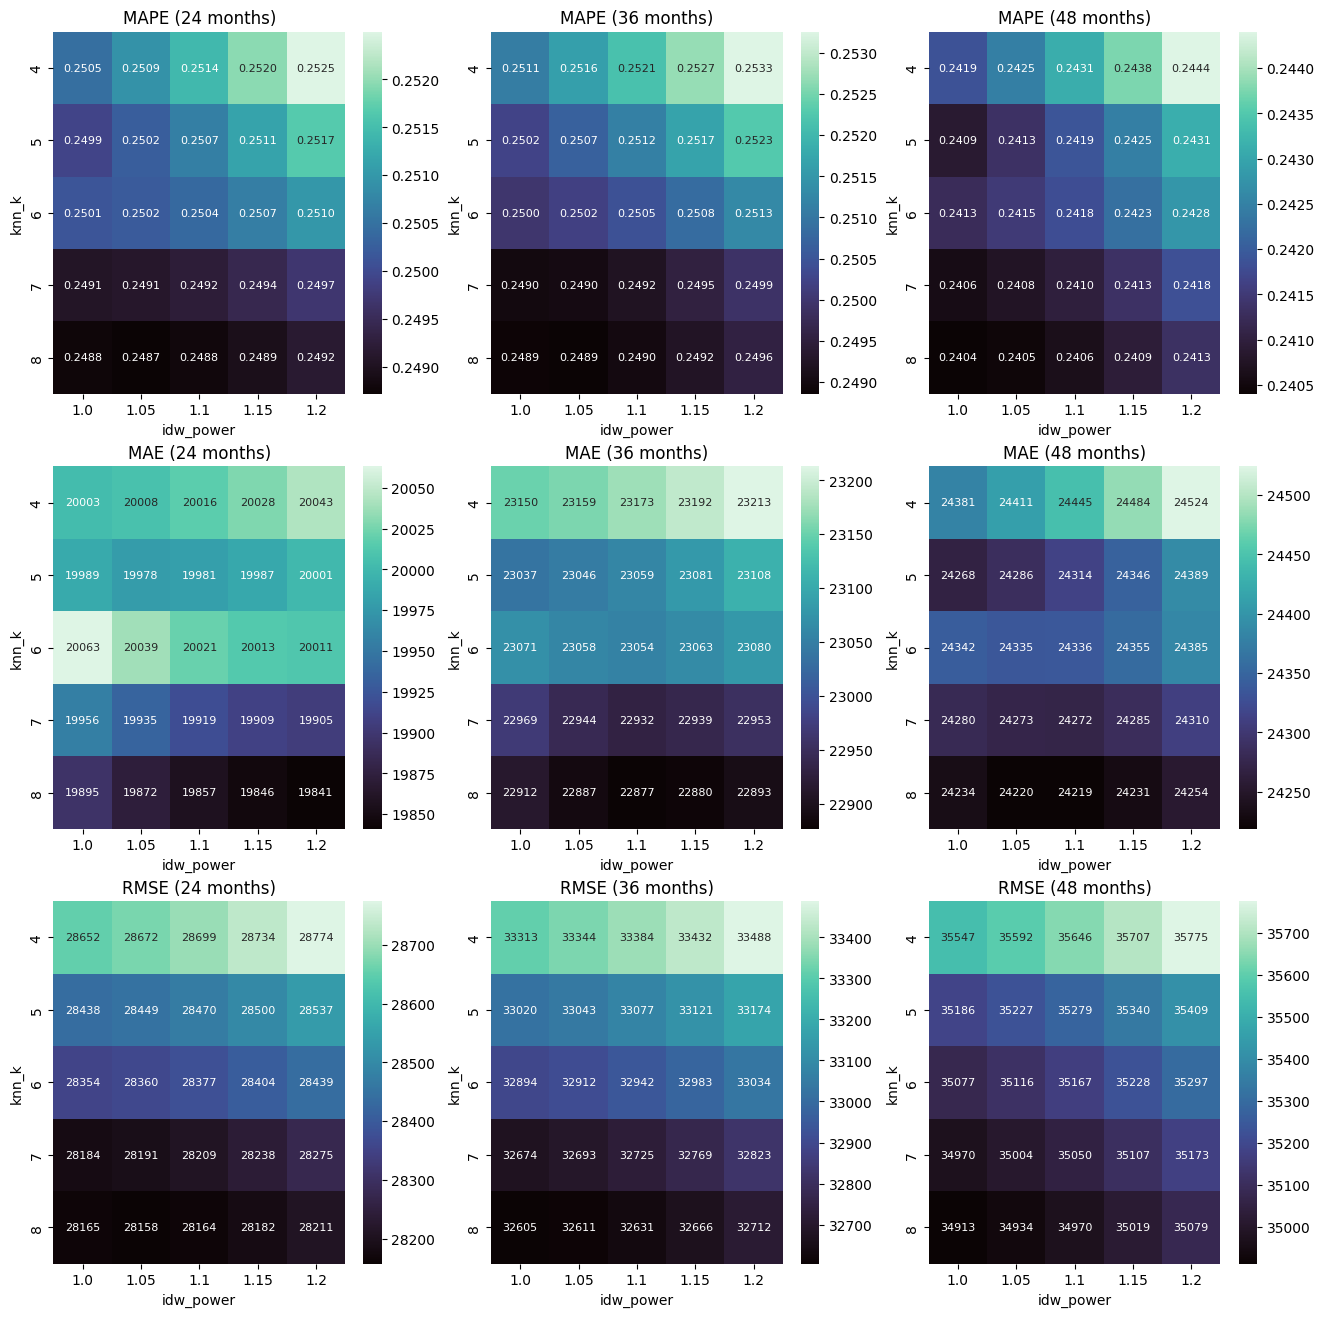

In [18]:
metric_names = ['MAPE', 'MAE', 'RMSE']
checkpoints = [24, 36, 48]
exp_reg_wt = 0.25

mask = (tuning_results['knn_k'] >= 4) & (tuning_results['idw_power'] <= 1.2) & (tuning_results['exp_reg_weight'] == exp_reg_wt)
subset = tuning_results[mask]

demo_utils.metrics_heatmaps(
    tuning_results_subset=subset,
    metric_names=['MAPE', 'MAE', 'RMSE'],
    month_checkpoints=[24, 36, 48],
    cmap='mako',
    heatmap_txt_fmt={'MAPE': '.4f', 'MAE': '.0f', 'RMSE': '.0f'}
)

Interestingly, it seems that MAE prefers stronger weighting in IDW early on; but that as time passes, it prefers a weaker IDW. But even so, the MAE scores for different `idw_power` values are somewhat tightly grouped; and to know whether that trend continues beyond 48 months would require us to train the models for a longer timeframe.

All three metrics generally prefer `k=8`, and `idw_power=1.05` is the best or nearly best for all metrics at all checkpoints. MAPE scores within `k=8` are all tightly grouped as well.

## Evaluation

Based on the hyperparameter tuning above, we'll evaluate the model with `(exp_regress_weight=0.25, k=8, idw_power=1.05)`.

In [19]:
selected_exp_reg_weight_power = 0.25
selected_knn_k = 8
selected_idw_power = 1.05

results = evaluate.evaluate(
    wells_train,
    wells_test,
    production_loader,
    exp_reg_models=exp_reg_models_by_weights[selected_exp_reg_weight_power],
    knn_k=selected_knn_k,
    idw_power=selected_idw_power,
    distance_calculator=dist_calculator,
    month_checkpoints=[24, 36, 48],
    metrics=metrics,
)

In [20]:
# Unpack this into a table.
score_data = {'month': [], 'MAE': [], 'MAPE': [], 'RMSE': []}
for chkpt, scores in results.items():
    score_data['month'].append(chkpt)
    for metric_name, score in scores.items():
        score_data[metric_name.upper()].append(score)
pd.DataFrame(score_data)

,month,MAE,MAPE,RMSE
0,24,20787.075166,0.256433,30652.983628
1,36,23971.760878,0.257522,35307.013197
2,48,25529.963713,0.253505,38287.425778


The MAPE at all three checkpoints is around 25%; and the MAE at 48 months is about 25,500 BBLs. These errors are higher than we would use for real world investment decisions. If a barrel of oil sells for $75, then a MAE of 25,500 BBLs is about $1.9 million. (For context, a typical oil well might cost around $10 million to drill.)

Even so, these scores are respectable for a model that uses only public data, without access to any sophisticated geological data.

# Future Improvements

I have some ideas of ways to potentially improve the model, either with different techniques or supplementing with additional or better data, which might or might not be available.

### Modified KNN / "fuzzy" K

Instead of finding the *k* nearest neighbors of a target location, a variation might be to find *all* neighbors within some parameter-specified distance threshold -- and still weight them by distance. This could be bounded by a maximum number of wells to include, and also a minimum (i.e., go beyond the distance threshold until we have at least `k` wells). I suspect this could have better results in areas with fewer wells, where there might be only 2 or 3 that are "close", because we would avoid reaching for far away wells with relatively little predictive value. But it is possible that IDW already accomplishes much of this, so testing is necessary to know for sure.

### More accurate location data

Ideally, more accurate distances could be achieved if we used the midpoint of the lateral itself, which might not be *precisely* the same as the midpoint between the SHL and BHL (for reasons I won't go into here), but that data isn't easily available for Colorado wells. It *could* probably be calculated with shapefiles available on Colorado's ECMC website, which might be worthwhile if we're trying to fully optimize this model.

### Additional completion data

Knowing the length of the lateral for each well is important, because it reveals how large of an area oil is being drawn from. But another data field that would be nice to have is the number of perforations in the lateral (the number of holes that are blown into the sides of the lateral with explosives, allowing oil to flow into the lateral). This data is available for some of the wells, but not all.